In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

#keras
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.experimental.preprocessing import Normalization


#others
import os
import json
from pathlib import Path
import joblib
import folium
import geojson
import geopandas as gpd
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor, plot_importance, plot_tree
import statsmodels.api as sm
from pandas.plotting import lag_plot
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
def grab_ticker(ticker):
    data = yf.download(ticker, start='2014-01-01', end='2022-01-01')
    return data
    

In [7]:
def get_closing_df(ticker):
    data = grab_ticker(ticker)
    df = pd.DataFrame(data['Close'])
    df.columns = ['Close']
    return df

In [48]:
class New_Model:
    
    def __init__(self, ticker):
        self.ticker = ticker
        self.n_input = 400
        self.n_feature = 1
        self.scaler = MinMaxScaler()
        
    def build_model(self):
        self.model = Sequential()

        self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(self.n_input, self.n_feature))) #(300, 1)
        self.model.add(AveragePooling1D(pool_size=2))

        self.model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        self.model.add(AveragePooling1D(pool_size=2))

        self.model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
        self.model.add(AveragePooling1D(pool_size=2))
        
        self.model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
        self.model.add(AveragePooling1D(pool_size=2))
        
        self.model.add(Flatten())
        self.model.add(Dense(units=64, activation='relu'))
        self.model.add(Dense(units=self.n_feature, activation='relu')) #1
        self.model.compile(optimizer='adam', loss='mse')

        #stochastic gradient descent sgd, mse is best for outlier detection
        return self.model
    
    def preprocessed_data(self):
        
        df = get_closing_df(self.ticker)
        self.ticker_train = df[:int(len(df) * 0.7)]
        self.ticker_test = df[int(len(df) * 0.7):]
        self.scaler.fit(self.ticker_train)
        scaled_train_ticker = self.scaler.transform(self.ticker_train)
        scaled_test_ticker = self.scaler.transform(self.ticker_test)
        
        #creating the generator for training and testing
        train_generator_ticker = TimeseriesGenerator(scaled_train_ticker, scaled_train_ticker, length=self.n_input, batch_size=1)
        test_generator_ticker = TimeseriesGenerator(scaled_test_ticker, scaled_test_ticker, length=self.n_input, batch_size=1)
        self.model.fit(train_generator_ticker, epochs=5, batch_size=50, verbose=2)
        
        
        test_predictions = []
        train_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])

        #train window
        for x,_ in train_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred_train = self.model.predict(x)
            
            #store that prediction
            train_predictions.append(current_pred_train[0])


        #reverse the scaled into normal prices
        self.train_predictions = self.scaler.inverse_transform(train_predictions)
        self.true_predictions = self.scaler.inverse_transform(test_predictions)
    
    def get_results(self):
        self.test_result = self.ticker_test[self.n_input:]
        self.test_result['predictions'] = self.true_predictions
        mse = mean_squared_error(y_true=self.test_result['Close'], y_pred=self.test_result['predictions'])
        print(mse)
        return self.test_result
        
    def plot_test_result_graph(self):
        self.test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.Close).set(title='{} Result Predictions'.format(self.ticker))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.predictions)
        
    def plot_train_result_graph(self):
        self.train_result = self.ticker_train[self.n_input:]
        self.train_result['predictions'] = self.train_predictions
        self.train_result.plot(figsize=(12,8))
        plt.title('{} Training Predictions'.format(self.ticker))
    
    def predict(self, target):
        df = get_closing_df(target)
        self.scaler.fit(df)
        scaled_test_df = self.scaler.transform(df)

        #creating the generator for training and testing
        test_generator_df = TimeseriesGenerator(scaled_test_df, scaled_test_df, length=self.n_input, batch_size=1)

        test_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_df:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])



        #reverse the scaled into normal prices
        self.test_predictions = self.scaler.inverse_transform(test_predictions)
        
        test_result = df[self.n_input:]
        test_result['predictions'] = self.test_predictions
        print(test_result)
        
        test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=test_result.index, y=test_result.Close)
        sns.scatterplot(x=test_result.index, y=test_result.predictions)
        mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
        print('MSE is: {}'.format(mse))
        

In [49]:
a = New_Model('AAPL')

In [50]:
a.build_model()

In [51]:
a.preprocessed_data()

[*********************100%***********************]  1 of 1 completed
Epoch 1/5
1010/1010 - 7s - loss: 0.0134
Epoch 2/5
1010/1010 - 6s - loss: 0.0014
Epoch 3/5
1010/1010 - 6s - loss: 0.0013
Epoch 4/5
1010/1010 - 6s - loss: 9.3217e-04
Epoch 5/5
1010/1010 - 6s - loss: 0.0011


In [52]:
a.get_results()

23.228644623027797


<ipython-input-48-89c2c4351dc6>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_result['predictions'] = self.true_predictions


,Close,predictions
Date,,
2021-03-12,121.029999,124.077985
2021-03-15,123.989998,124.700633
2021-03-16,125.570000,125.999177
2021-03-17,124.760002,128.087361
2021-03-18,120.529999,128.836233
...,...,...
2021-12-27,180.330002,180.693951
2021-12-28,179.289993,183.318679
2021-12-29,179.380005,185.142743


<ipython-input-48-89c2c4351dc6>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_result['predictions'] = self.train_predictions


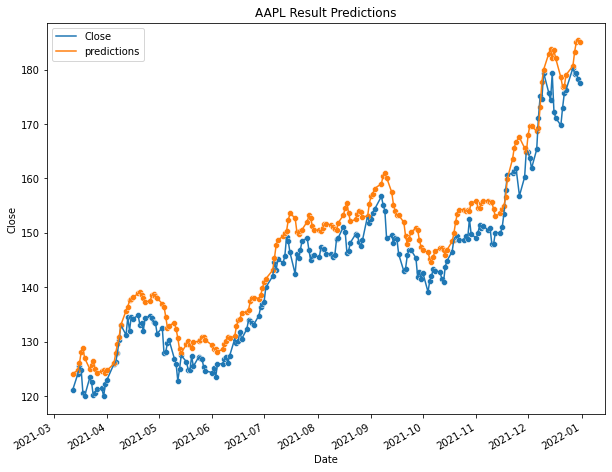

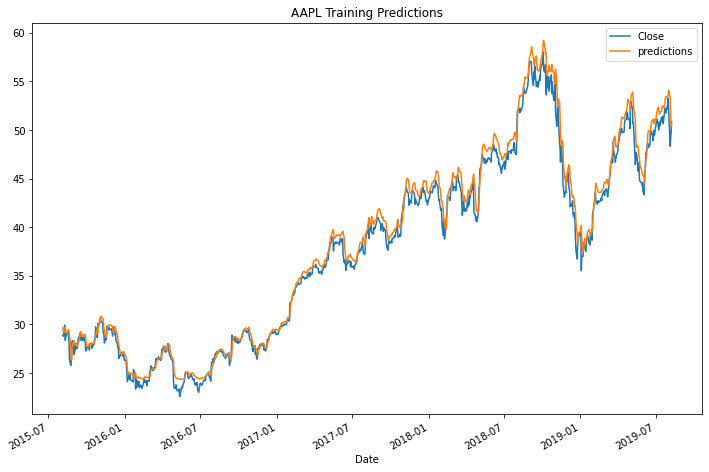

In [53]:
a.plot_test_result_graph()
a.plot_train_result_graph()

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-08-05  190.270004   189.616674
2015-08-06  174.490005   192.067923
2015-08-07  175.520004   187.083804
2015-08-10  176.960007   182.057659
2015-08-11  173.929993   181.631091
...                ...          ...
2021-12-27  568.340027   574.794389
2021-12-28  564.710022   583.143904
2021-12-29  563.599976   586.830618
2021-12-30  561.419983   586.395348
2021-12-31  556.760010   585.130242

[1615 rows x 2 columns]
MSE is: 115.65992828830915


<ipython-input-48-89c2c4351dc6>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


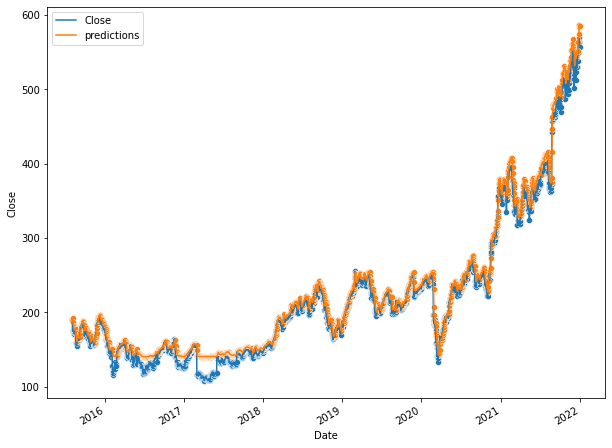

In [54]:
a.predict('PANW')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-08-05    5.145000    58.652248
2015-08-06    5.112500    58.652204
2015-08-07    5.745000    58.652091
2015-08-10    5.945000    58.651821
2015-08-11    5.915000    58.651157
...                ...          ...
2021-12-27  309.450012   303.832912
2021-12-28  303.220001   312.510383
2021-12-29  300.010010   316.548896
2021-12-30  295.859985   314.207806
2021-12-31  294.109985   311.445850

[1615 rows x 2 columns]
MSE is: 653.1706984113243


<ipython-input-48-89c2c4351dc6>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


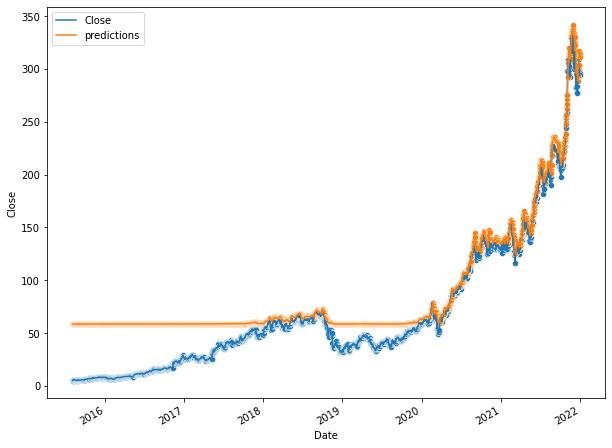

In [55]:
a.predict('NVDA')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2015-08-05   74.980003    82.918784
2015-08-06   73.580002    82.902659
2015-08-07   74.209999    82.867596
2015-08-10   74.379997    82.857307
2015-08-11   73.360001    82.862938
...                ...          ...
2021-12-27  217.630005   223.224510
2021-12-28  218.050003   223.793343
2021-12-29  218.169998   224.664308
2021-12-30  217.869995   224.982483
2021-12-31  216.710007   224.954100

[1615 rows x 2 columns]
MSE is: 35.50731767330884


<ipython-input-48-89c2c4351dc6>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


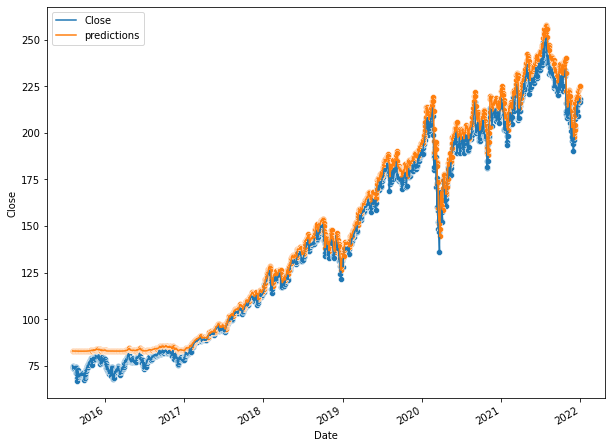

In [56]:
a.predict('V')